<a href="https://colab.research.google.com/github/DanielCreeklear/TransitivityFootbalChampionships/blob/main/Campeonatos_de_futebol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Dataset

In [ ]:
"""
Libertadores: https://www.kaggle.com/datasets/ernestonlm/conmebol-libertadores-results-from-2011-to-2022
FIFA WorldCup: https://www.kaggle.com/datasets/abecklas/fifa-world-cup
Brasileirão: https://www.kaggle.com/datasets/ricardomattos05/jogos-do-campeonato-brasileiro
"""
BRASILEIRAO_PATH = '/content/Brasileirao_Matches.csv'
WORLD_CUP_PATH = '/content/WorldCupMatches.csv'
LIBERTADORES_PATH = '/content/libertadores-results-ds.csv'

## Championships classes

In [ ]:
class Cup:
  def __init__(self) -> None:
    self.df = pd.DataFrame()
    self.teams = list()
    self.index_teams = dict()
    self.amount_teams = int()
    self.amount_matches = int()


class Brasileirao(Cup):
  COLUMN_HOME_TEAM = 'home_team'
  COLUMN_AWAY_TEAM = 'away_team'

  def __init__(self, df) -> None:
    super().__init__()
    self.df = df.dropna(subset=[self.COLUMN_HOME_TEAM, self.COLUMN_AWAY_TEAM])
    self.teams = list(set(df[self.COLUMN_HOME_TEAM].tolist() + df[self.COLUMN_AWAY_TEAM].tolist()))
    self.index_teams = {}
    self.amount_teams = len(self.teams)
    self.amount_matches = len(self.df)

    self.set_index_teams()

  def set_index_teams(self) -> None:
    for i, team in enumerate(self.teams):
      self.index_teams[team] = i


class WorldCup(Cup):
  COLUMN_HOME_TEAM = 'Home Team Name'
  COLUMN_AWAY_TEAM = 'Away Team Name'

  def __init__(self, df) -> None:
    super().__init__()
    self.df = df.dropna(subset=[self.COLUMN_HOME_TEAM, self.COLUMN_AWAY_TEAM])
    self.teams = list(set(df[self.COLUMN_HOME_TEAM].tolist() + df[self.COLUMN_AWAY_TEAM].tolist()))
    self.index_teams = {}
    self.amount_teams = len(self.teams)
    self.amount_matches = len(self.df)

    self.set_index_teams()

  def set_index_teams(self) -> None:
    for i, team in enumerate(self.teams):
      self.index_teams[team] = i


class Libertadores(Cup):
  COLUMN_HOME_TEAM = 'Home Club'
  COLUMN_AWAY_TEAM = 'Away Club'

  def __init__(self, df) -> None:
    super().__init__()
    self.df = df.dropna(subset=[self.COLUMN_HOME_TEAM, self.COLUMN_AWAY_TEAM])
    self.teams = list(set(df[self.COLUMN_HOME_TEAM].tolist() + df[self.COLUMN_AWAY_TEAM].tolist()))
    self.index_teams = {}
    self.amount_teams = len(self.teams)
    self.amount_matches = len(self.df)

    self.set_index_teams()

  def set_index_teams(self) -> None:
    for i, team in enumerate(self.teams):
      self.index_teams[team] = i

## Championships objects 

In [ ]:
brasileirao = Brasileirao(pd.read_csv(BRASILEIRAO_PATH))
libertadores = Libertadores(pd.read_csv(LIBERTADORES_PATH))
world_cup = WorldCup(pd.read_csv(WORLD_CUP_PATH))

In [ ]:
brasileirao.df

,datetime,home_team,home_team_state,away_team,away_team_state,home_goal,away_goal,season,round
0,2012-05-19 18:30:00,Palmeiras-SP,SP,Portuguesa-SP,SP,1.0,1.0,2012,1
1,2012-05-19 18:30:00,Sport-PE,PE,Flamengo-RJ,RJ,1.0,1.0,2012,1
2,2012-05-19 21:00:00,Figueirense-SC,SC,Nautico-PE,PE,2.0,1.0,2012,1
3,2012-05-20 16:00:00,Ponte Preta-SP,SP,Atletico-MG,MG,0.0,1.0,2012,1
4,2012-05-20 16:00:00,Corinthians-SP,SP,Fluminense-RJ,RJ,0.0,1.0,2012,1
...,...,...,...,...,...,...,...,...,...
4175,2022-11-13 16:00:00,Internacional-RS,RS,Palmeiras-SP,SP,NaN,NaN,2022,38
4176,2022-11-13 16:00:00,Ceara-CE,CE,Juventude-RS,RS,NaN,NaN,2022,38
4177,2022-11-13 16:00:00,Goias-GO,GO,Sao Paulo-SP,SP,NaN,NaN,2022,38
4178,2022-11-13 16:00:00,Cuiaba-MT,MT,Coritiba-PR,PR,NaN,NaN,2022,38


# Graph

## Basic information

In [ ]:
class GraphCup:
  def __init__(self, cup: Cup):
    self.cup = cup
    self.nodes = cup.teams
    self.adjacency_matrix = [[0 if row != column else 1 for row in range(len(self.nodes))] for column in range(len(self.nodes))]
    self.row_count = [0 for row in range(len(self.nodes))]
    self.column_count = [0 for row in range(len(self.nodes))]
    self.match_pairs = []
    self.G = nx.Graph()

  def generate_nodes(self) -> None:
    for index, row in self.cup.df.iterrows():
      home_club = row[self.cup.COLUMN_HOME_TEAM]
      away_club = row[self.cup.COLUMN_AWAY_TEAM]
      self.adjacency_matrix[self.cup.index_teams[home_club]][self.cup.index_teams[away_club]] += 1
      self.adjacency_matrix[self.cup.index_teams[away_club]][self.cup.index_teams[home_club]] += 1
      self.match_pairs.append((home_club, away_club))
      print(f"Match: {home_club} x {away_club}")
      print(f"Number of matches between these two teams: {self.adjacency_matrix[self.cup.index_teams[home_club]][self.cup.index_teams[away_club]]}")
      print("="*10)
    self.G.add_edges_from(self.match_pairs)
  
  def print_adjacency_matrix(self) -> None:
    for row in self.adjacency_matrix:
      print(row)

  def calculate_totals(self) -> None:
    for i in range(len(self.nodes)):
      for j in range(len(self.nodes)):
          self.row_count[i] += self.adjacency_matrix[i][j]
          self.column_count[j] += self.adjacency_matrix[i][j]

  def show_graph(self) -> None:
    plt.figure(1,figsize=(12,12)) 
    nx.draw(self.G, node_size=60)

  def get_transitivity(self) -> float:
    return nx.transitivity(self.G)

In [ ]:
graph_brasileirao = GraphCup(brasileirao)
graph_libertadores = GraphCup(libertadores)
graph_world_cup = GraphCup(world_cup)

In [ ]:
graph_brasileirao.generate_nodes()
graph_brasileirao.calculate_totals()

graph_libertadores.generate_nodes()
graph_libertadores.calculate_totals()

graph_world_cup.generate_nodes()
graph_world_cup.calculate_totals()

A saída de streaming foi truncada nas últimas 5000 linhas.
Number of matches between these two teams: 2
Match: Botafogo FR x San Lorenzo de Almagro
Number of matches between these two teams: 2
Match: Lanús x Caracas
Number of matches between these two teams: 1
Match: Guaraní x Universidad de Chile
Number of matches between these two teams: 1
Match: Atlético PR x Sporting Cristal
Number of matches between these two teams: 1
Match: Botafogo FR x Deportivo Quito
Number of matches between these two teams: 1
Match: Santa Fe x Monarcas Morelia
Number of matches between these two teams: 1
Match: Nacional x Oriente Petrolero
Number of matches between these two teams: 1
Match: Caracas x Lanús
Number of matches between these two teams: 2
Match: Universidad de Chile x Guaraní
Number of matches between these two teams: 2
Match: Deportivo Quito x Botafogo FR
Number of matches between these two teams: 2
Match: Sporting Cristal x Atlético PR
Number of matches between these two teams: 2
Match: Oriente

## Graph visualization

### Image

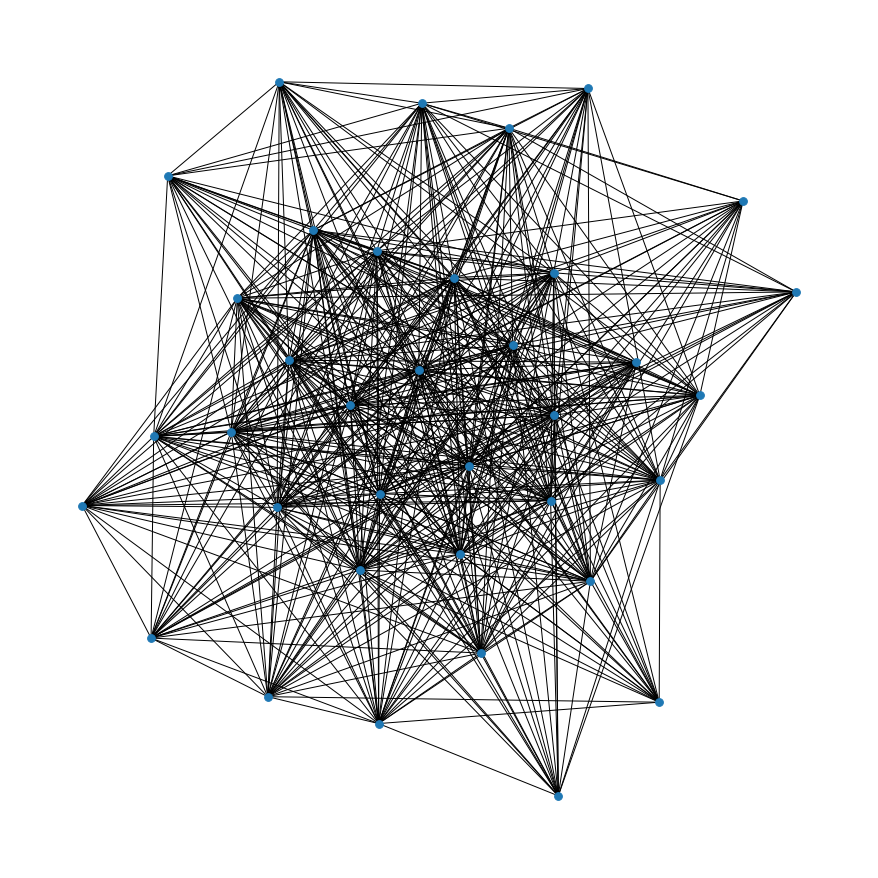

In [ ]:
graph_brasileirao.show_graph()

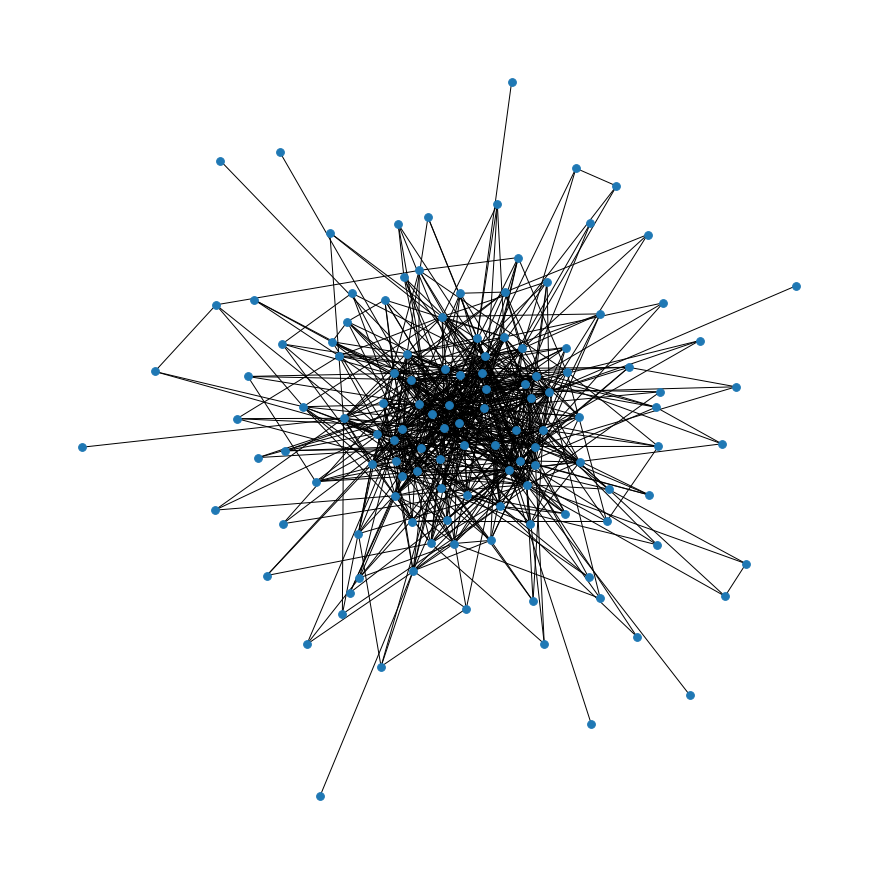

In [ ]:
graph_libertadores.show_graph()

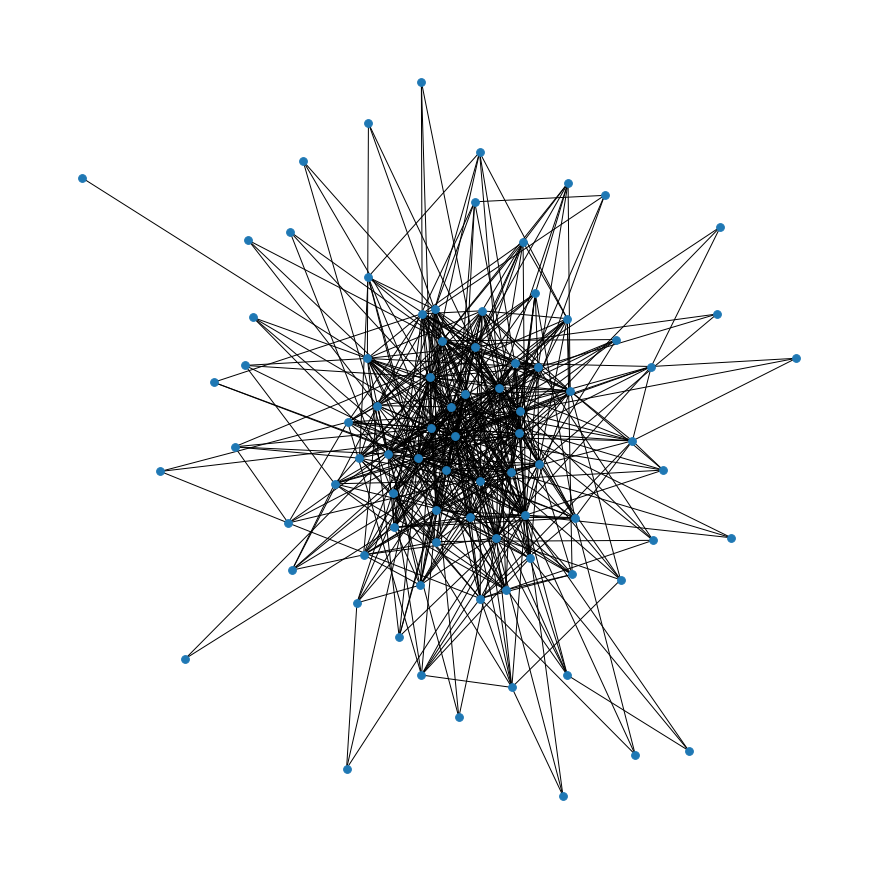

In [ ]:
graph_world_cup.show_graph()

## Properties

In [ ]:
# Transitividade
graph_brasileirao.get_transitivity()

0.8818316100443131

In [ ]:
# Transitividade
graph_libertadores.get_transitivity()

0.28070306656694094

In [ ]:
# Transitividade
graph_world_cup.get_transitivity()

0.42124426151654265

(array([29., 15.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <a list of 10 Patch objects>)

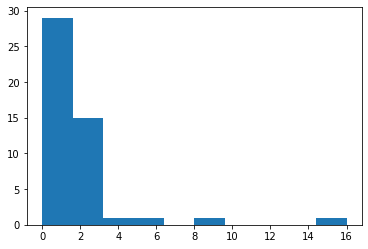

In [ ]:
plt.hist(nx.degree_histogram(graph_world_cup.G))